Copied from: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Loading

In [2]:
df = pd.read_csv("../data/Concrete_Discrete_16032021.csv")
df.head()

,Image_Action.x,Image_People.x,Image_Emotion.x,Image_Vivid.x,Image_Scenes.x,Response.x,Steps,Effective,Concrete,Emotion,...,Concrete.HighCount,Concrete.HighDensity,Concrete.ExtremeCount,Concrete.ExtremeDensity,Concrete.BigramHighCount,WordCount,Concrete.Level,Concrete.Low,Concrete.Medium,Concrete.High
0,1.0,3.0,3.0,3.0,3.0,I would come up with some possible suggestions...,1.5,2.5,2.5,2.5,...,32,0.201258,12,0.075472,0,159,High,0,0,1
1,2.0,4.0,3.0,4.0,4.0,I would think of a close friend or family memb...,1.0,1.0,1.5,1.5,...,28,0.291667,9,0.093750,1,96,Medium,0,1,0
2,1.0,2.0,1.0,1.0,1.0,Make a plan to reach out to friends and family...,1.5,2.0,1.5,1.5,...,8,0.258065,2,0.064516,1,31,Medium,0,1,0
3,1.0,3.0,3.0,3.0,4.0,I would firstly engage in having a coffee with...,1.5,2.0,2.0,2.0,...,20,0.256410,6,0.076923,0,78,Medium,0,1,0
4,1.0,3.0,3.0,2.0,1.0,This morning I feel lonely as I haven't seen a...,2.0,1.5,2.0,1.5,...,46,0.272189,14,0.082840,0,169,Medium,0,1,0


In [3]:
df.shape

(1236, 50)

Dropping invalid rows

In [4]:
df = df[df.invalid_response == 0]
df.shape

(1088, 50)

Keeping only the important columns

In [5]:
df = df[["Response.x", "Concrete.Level"]]
df = df.rename(columns={"Response.x":"Response", "Concrete.Level":"Concrete"})

df.head()

,Response,Concrete
0,I would come up with some possible suggestions...,High
1,I would think of a close friend or family memb...,Medium
2,Make a plan to reach out to friends and family...,Medium
3,I would firstly engage in having a coffee with...,Medium
4,This morning I feel lonely as I haven't seen a...,Medium


Converting string to numeric

In [6]:
mapping = {
    "Low": 0,
    "Medium": 1,
    "High": 2
}
df = df.replace({'Concrete': mapping})

df.head()

,Response,Concrete
0,I would come up with some possible suggestions...,2
1,I would think of a close friend or family memb...,1
2,Make a plan to reach out to friends and family...,1
3,I would firstly engage in having a coffee with...,1
4,This morning I feel lonely as I haven't seen a...,1


Removing invalid rows (that haven't been caught by invalid_response)

In [7]:
df = df.dropna()
df.shape

(1084, 2)

# Data Preprocessing

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
sample_text = df.Response[20]

tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I would make a list of all the people I could contact, and method of contacting (eg email, online, video chat, phone call).  I would contact my family by phone call, or my friends by social media.  I would make sure I joined the virtual chat groups set up by my sporting groups, and complete the fun challenges that they have sent me.
   Tokens: ['I', 'would', 'make', 'a', 'list', 'of', 'all', 'the', 'people', 'I', 'could', 'contact', ',', 'and', 'method', 'of', 'contact', '##ing', '(', 'e', '##g', 'email', ',', 'online', ',', 'video', 'chat', ',', 'phone', 'call', ')', '.', 'I', 'would', 'contact', 'my', 'family', 'by', 'phone', 'call', ',', 'or', 'my', 'friends', 'by', 'social', 'media', '.', 'I', 'would', 'make', 'sure', 'I', 'joined', 'the', 'virtual', 'chat', 'groups', 'set', 'up', 'by', 'my', 'sporting', 'groups', ',', 'and', 'complete', 'the', 'fun', 'challenges', 'that', 'they', 'have', 'sent', 'me', '.']
Token IDs: [146, 1156, 1294, 170, 2190, 1104, 1155, 1103, 1234, 

In [10]:
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=100,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation=True
)
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'would',
 'make',
 'a',
 'list',
 'of',
 'all',
 'the',
 'people',
 'I',
 'could',
 'contact',
 ',',
 'and',
 'method',
 'of',
 'contact',
 '##ing',
 '(',
 'e',
 '##g',
 'email',
 ',',
 'online',
 ',',
 'video',
 'chat',
 ',',
 'phone',
 'call',
 ')',
 '.',
 'I',
 'would',
 'contact',
 'my',
 'family',
 'by',
 'phone',
 'call',
 ',',
 'or',
 'my',
 'friends',
 'by',
 'social',
 'media',
 '.',
 'I',
 'would',
 'make',
 'sure',
 'I',
 'joined',
 'the',
 'virtual',
 'chat',
 'groups',
 'set',
 'up',
 'by',
 'my',
 'sporting',
 'groups',
 ',',
 'and',
 'complete',
 'the',
 'fun',
 'challenges',
 'that',
 'they',
 'have',
 'sent',
 'me',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Trying out the BERT Tokenizer...

Deciding on sequence length

In [11]:
token_lens = []
for txt in df.Response:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (710 > 512). Running this sequence through the model will result in indexing errors


c:\users\magab\anaconda3\envs\carestudy3.8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


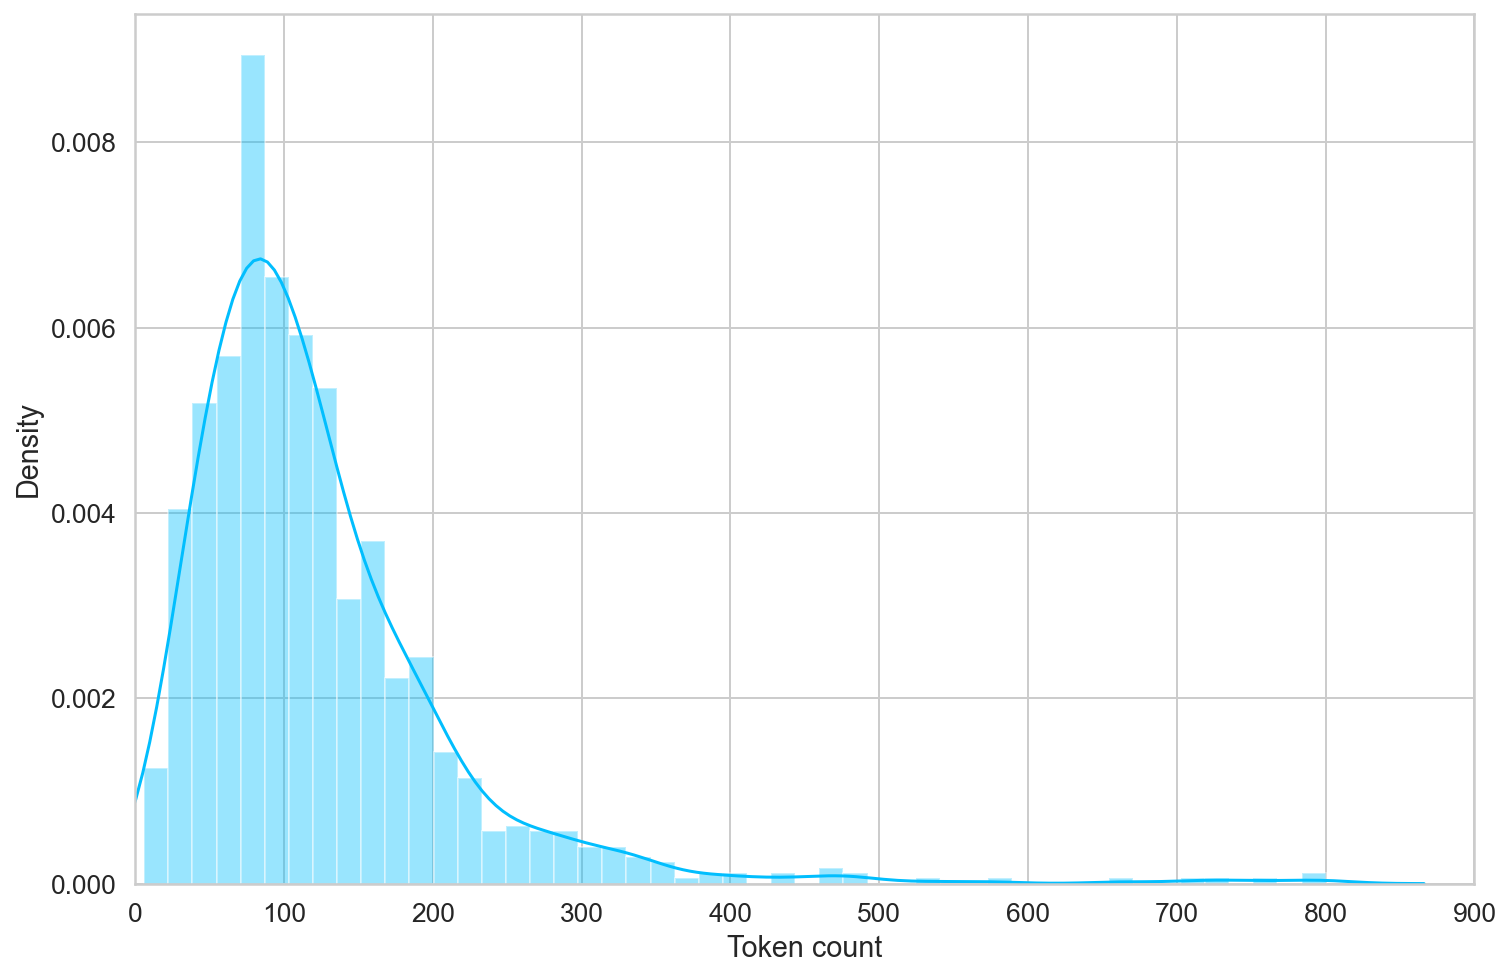

In [12]:
sns.distplot(token_lens)
plt.xlim([0, 900]);
plt.xlabel('Token count');

A majority of our responses have 400 or less words.

In [13]:
MAX_LEN = 400 #Max of BERT is 512

In [14]:
class ConcretenessDataset(Dataset):
  def __init__(self, response, targets, tokenizer, max_len):
    self.response = response
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.response)
  def __getitem__(self, item):
    response = str(self.response[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      response,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )
    return {
      'response': response,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

## Train test split

In [15]:
df_train, df_test = train_test_split(
  df,
  stratify=df.Concrete,
  test_size=0.2
)
df_val, df_test = train_test_split(
  df_test,
  stratify=df_test.Concrete,
  test_size=0.5
)

In [16]:
df_train.shape, df_val.shape, df_test.shape

((867, 2), (108, 2), (109, 2))

Checking class balance...

c:\users\magab\anaconda3\envs\carestudy3.8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


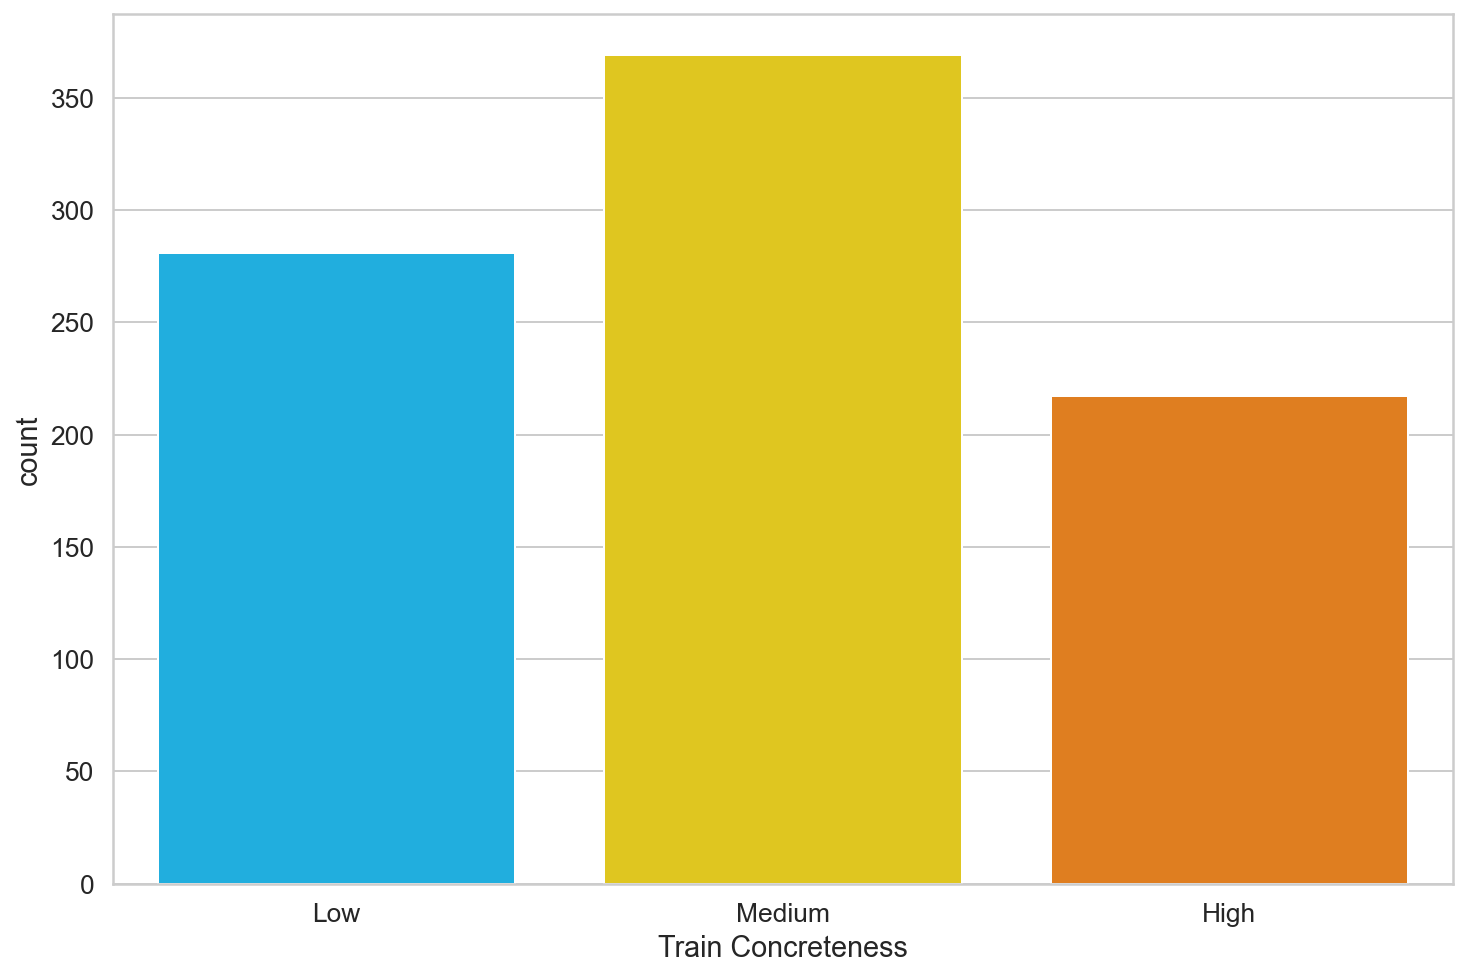

In [17]:
class_names = ['Low', 'Medium', 'High']
ax = sns.countplot(df_train.Concrete)
plt.xlabel('Train Concreteness')
ax.set_xticklabels(class_names);

c:\users\magab\anaconda3\envs\carestudy3.8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


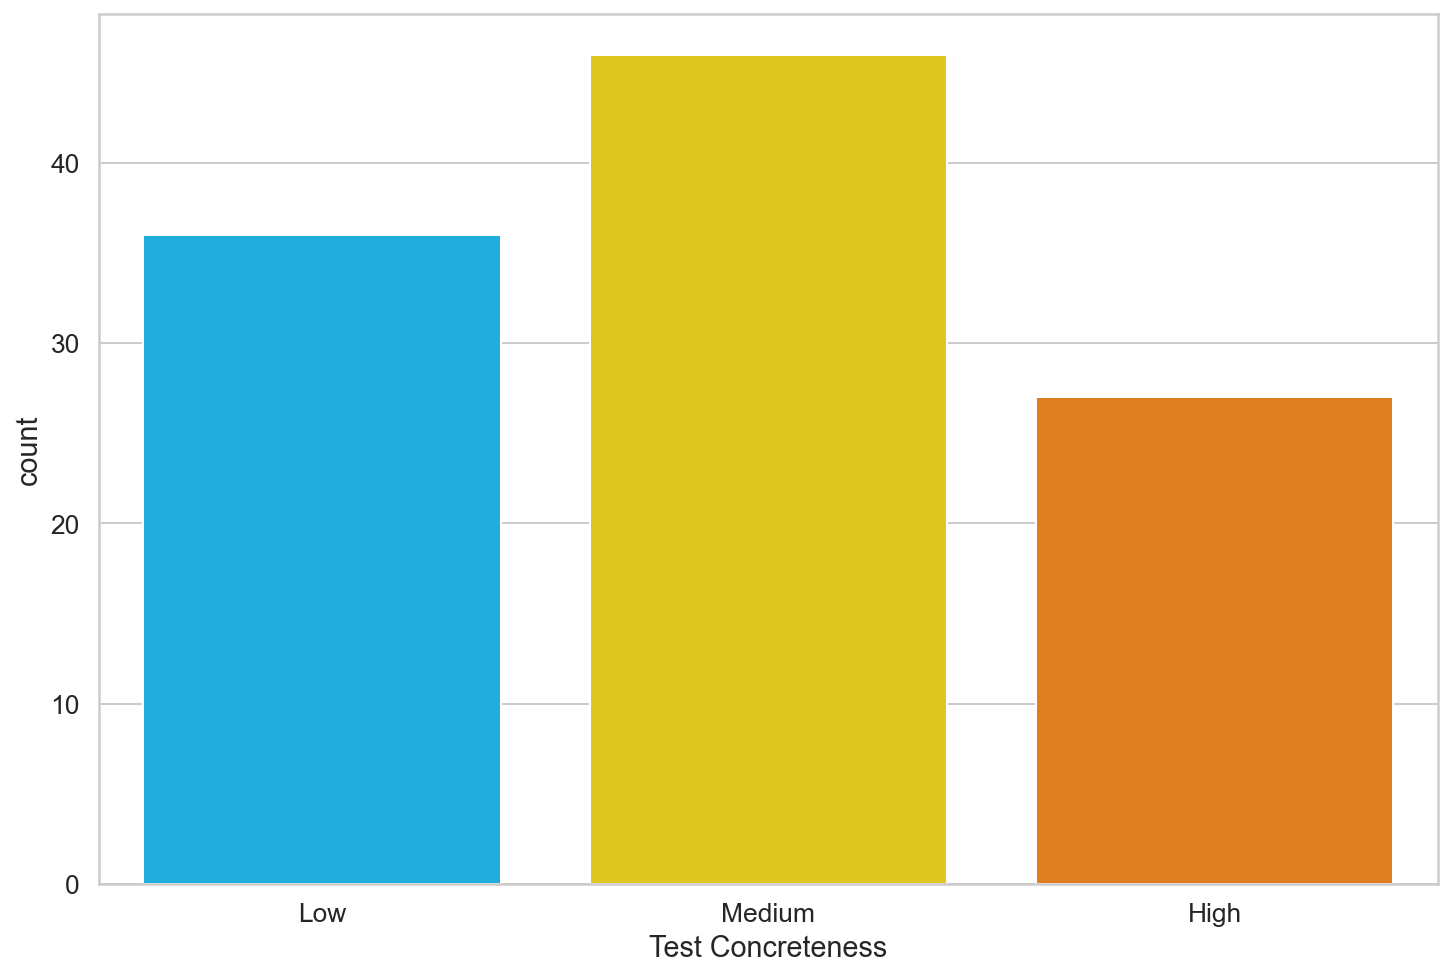

In [18]:
ax = sns.countplot(df_test.Concrete)
plt.xlabel('Test Concreteness')
ax.set_xticklabels(class_names);

c:\users\magab\anaconda3\envs\carestudy3.8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


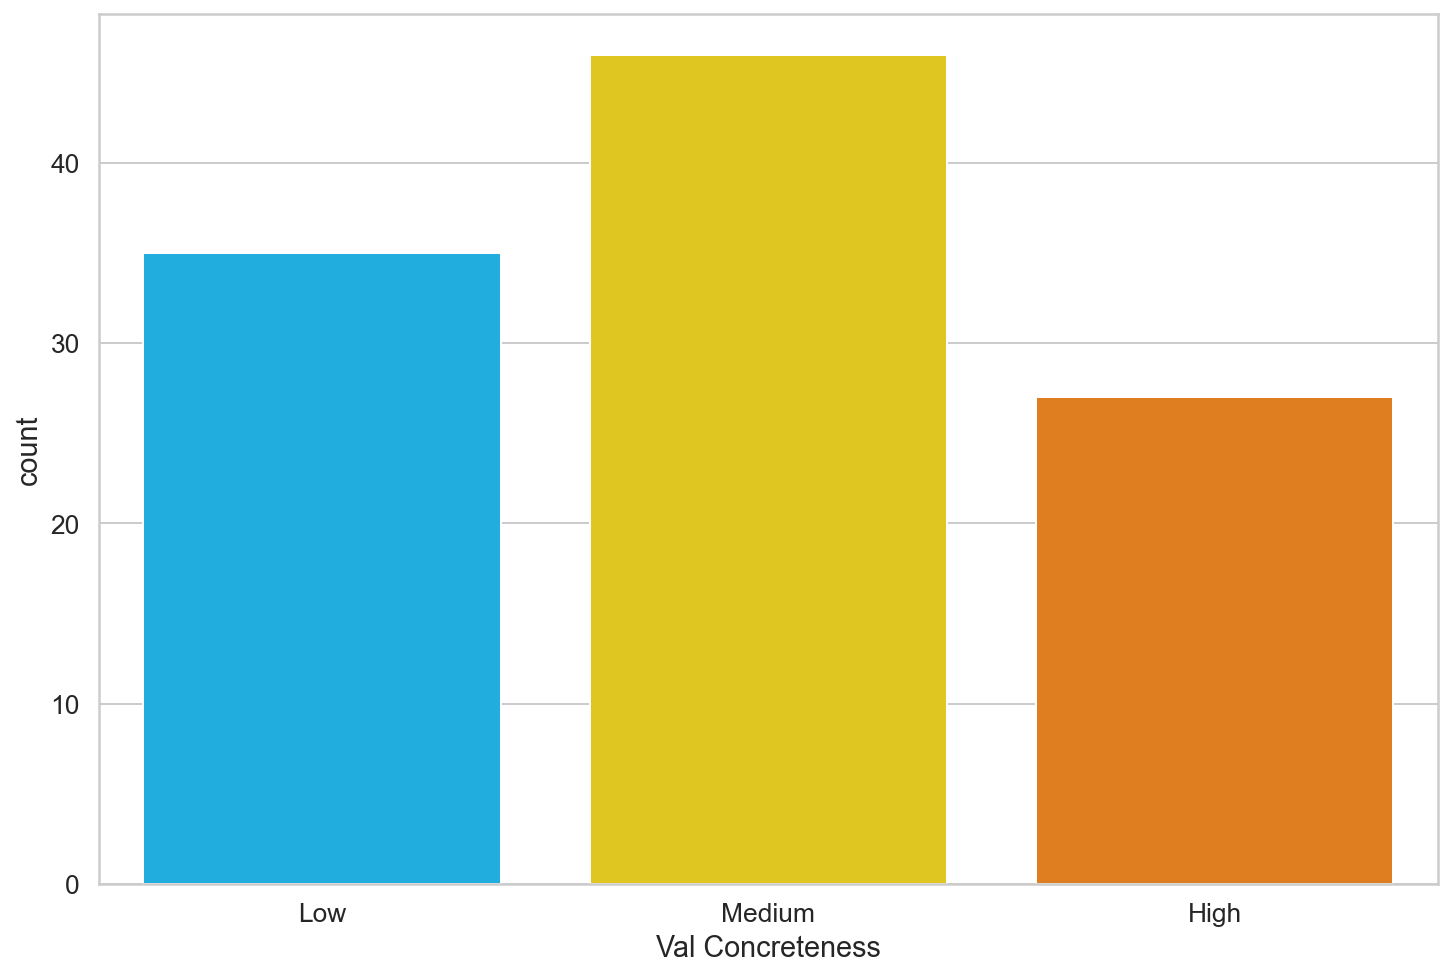

In [19]:
ax = sns.countplot(df_val.Concrete)
plt.xlabel('Val Concreteness')
ax.set_xticklabels(class_names);

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ConcretenessDataset(
    response=df.Response.to_numpy(),
    targets=df.Concrete.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [21]:
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Concreteness Predictor

In [22]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [23]:
class ConcretenessClassifier(nn.Module):
  def __init__(self):
    super(ConcretenessClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, 3) # 3 classes: Low, Medium, High
    
  def forward(self, input_ids, attention_mask):
    base_model_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    output = self.drop(base_model_output.pooler_output)
    return self.out(output)

In [24]:
model = ConcretenessClassifier()
model = model.to(device)

In [25]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
loss_fn = nn.CrossEntropyLoss().to(device)

In [26]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 20)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
'''
val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
'''

Epoch 1/10
--------------------


In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  response_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["response"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      response_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return response_texts, predictions, prediction_probs, real_values

In [ ]:
y_response_text, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Concreteness')
  plt.xlabel('Predicted Concreteness');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 52
response_text = y_response_text[idx]
true_concreteness = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(response_text)))
print()
print(f'True Concreteness: {class_names[true_concreteness]}')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Concreteness')
plt.xlabel('Probability')
plt.xlim([0, 1]);

# Predicting on raw text

In [ ]:
response_text = "Mr Mackay can recall an instance where he was visiting a three-bedroom home in Victoria Park and another renter offered an additional $80 a week on top of the advertised price off the cuff."

In [ ]:
encoded_review = tokenizer.encode_plus(
      response_text,
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {response_text}')
print(f'Concreteness  : {class_names[prediction]}')